## Решающие деревья

Пензин М.С.

penzin.ml.tsu@gmail.com

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

## Решающее дерево

**Решающее дерево (Decision Tree)** - инструмент принятия решений. Широко используется в различных областях, в том числе и машинном обучении.

### Стоит ли идти на улицу?

<center><img src="walk.png"></center>

## Бинарное дерево

<center><img src="bin.png"></center>

## Задачи

* __Классификация__ - в листьях дерева окажется признак указывающий на класс, к которому относится объект
* __Регрессия__ - в листьях окажется значение целевой функции в зависимости от признаков объекта.

## Вопросы

* Как построить решающее дерево?
* Какие вопросы задавать дереву?
* Какие значения признаков выбрать?

Допустим нужно отгадать знаменитость, задавая вопросы. Ответ может быть либо **"Да"**, либо __"Нет"__.

## Что лучше?

"Это Ричард Фейман?" **Vs** "Это женщина?"

Лучше тот, что дает нам наибольшую информацию.

## Энтропия

Для системы с $N$ состояниями можно определить энтропию Шеннона:

$$
S = - \sum\limits_{i = 1}^{N} p_i \log_2 p_i
$$

## Пример

Пусть у нас есть набор объектов, класс которых зависит исключительно от некой целочисленной координаты $x$.

(Пример взят [отсюда](https://habr.com/ru/post/171759/))


In [2]:
train = np.arange(0, 20)
x = train
target = np.array([
    0, 1, 1, 1, 
    1, 0, 0, 0, 
    0, 1, 1, 1, 
    1, 0, 0, 0, 
    0, 0, 0, 1
])

In [3]:
def show_traits(x, y, width):
    p = np.bincount(y) / y.shape[0]   
    S = (- np.nan_to_num(p * np.log2(p))).sum()
    
    plt.figure(figsize=(width,0.4))
    plt.title("S = %f" % S)
    ax = plt.scatter(x, np.zeros(x.shape), c=y, 
                     cmap=plt.get_cmap("Wistia"), edgecolors='k', s=100,
                     vmin=0, vmax=1)
    ax.axes.set_xticks(x);
    ax.axes.spines['right'].set_color('none')
    ax.axes.spines['left'].set_color('none')
    ax.axes.spines['top'].set_color('none')
    ax.axes.set_yticks([])        
    plt.show()    
    return S

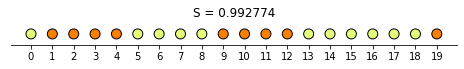

In [4]:
s0 = show_traits(x, target, 8)

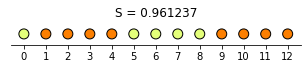

In [5]:
q1 = x <= 12
s1 = show_traits(x[q1], target[q1], 8 * (q1.sum() / q1.shape[0]))

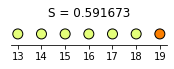

In [6]:
q2 = x > 12
s2 = show_traits(x[q2], target[q2], 8 * (q2.sum() / q2.shape[0]))

## Прирост информации

Формально, мы можем определить прирост информации (Information gain) как

$$
IG = S_0 - \sum\limits_{q=1}^{Q} \frac{N_q}{N} S_q
$$

Если присмотреться, то можно заметить, что $P_q = \frac{N_q}{N}$ - это доля объектов в ветке $q$. Фактически мы вычитаем среднюю взвешенную энтропию.

In [7]:
IG = s0 - q1.sum()/x.shape[0] * s1 - q2.sum()/x.shape[0] * s2
print("Прирост информации =", IG)

Прирост информации = 0.16088518841412436


<img src="tree.png">

Мы получили дерево, которое идеально описывает наши данные => переобучено.

* фиксировать глубину дерева
* отсечь ветви

## Неопределенность Джини

Неопределенность Джини (Gini impurity) - это альтернативный критерий разбиения дерева в задаче классификации

$$
G = 1 - \sum\limits_q (p_k)^2
$$

## Ошибка классификации

$$
M = 1 - \max p_k
$$

Для бинарной классификации, критерии энтропии и джини дают практически одинаковый результат

$$
S = -p_+ \log_2 p_+ - p_-\log_2 p_- = -p_+ \log_2 p_+ - (1 - p_+) \log_2 (1-p_+)
$$

$$
G = 1 - p_+^2 - p_-^2 = 2 p_+ (1 - p_+)
$$

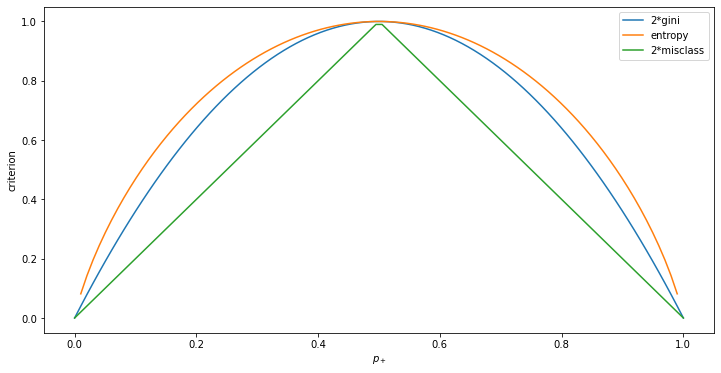

In [8]:
x = np.linspace(0, 1, 100)
plt.plot(x, 4.0 * x * (1 - x), label="2*gini")
plt.plot(x, -x*np.log2(x) - (1-x)*np.log2(1-x), label="entropy")
plt.plot(x, 2*(1 - np.maximum(x, 1-x)), label="2*misclass")
plt.xlabel("$p_+$"); plt.ylabel("criterion"); plt.legend()
plt.show()

## Пример

In [9]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(train.reshape(-1, 1), target)
predict = tree.predict(train.reshape(-1, 1))
(predict == target).sum() / target.shape[0]

1.0

In [10]:
from sklearn.tree import export_graphviz
export_graphviz(tree, feature_names=['x'], 
                out_file="sktree.dot", filled=True)
!dot -Tpng 'sktree.dot' -o 'sktree.png'

'dot' is not recognized as an internal or external command,
operable program or batch file.


<img src="sktree.png">

Откуда возникло 12.5, 8.5 и прочее?

In [11]:
df = pd.DataFrame({"X": train, "Target": target})
df[["X", "Target"]][11:15]

,X,Target
11,11,1
12,12,1
13,13,0
14,14,0


Если признаков несколько, то значения также сортируются, но уже по нескольким признакам. Затем значение признака также берется в виде среднего между двумя значениями, при которых происходит смена класса.

In [12]:
# Добавим второй признак. Сгенерируем его в виде случайной последовательности
df = pd.DataFrame({"X": train, "Y": np.random.normal(size=train.shape), "Target": target})

In [13]:
df[["X", "Y", "Target"]].sort_values(by=["X", "Y"])

,X,Y,Target
0,0,-1.067710,0
1,1,-0.311942,1
2,2,-0.775919,1
3,3,-1.832913,1
4,4,0.810853,1
5,5,-1.993433,0
6,6,0.142342,0
7,7,-0.220639,0
8,8,-1.648091,0
9,9,-0.225880,1


In [14]:
df[["X", "Y", "Target"]].sort_values(by=["Y", "X"])

,X,Y,Target
17,17,-2.260848,0
5,5,-1.993433,0
3,3,-1.832913,1
8,8,-1.648091,0
14,14,-1.073164,0
0,0,-1.067710,0
19,19,-1.004867,1
16,16,-0.916850,0
2,2,-0.775919,1
13,13,-0.573058,0


In [15]:
tree.fit(df[["X", "Y"]], df["Target"])
export_graphviz(tree, feature_names=['x', 'y'], 
                out_file="sktree2.dot", filled=True)
!dot -Tpng 'sktree2.dot' -o 'sktree2.png'

'dot' is not recognized as an internal or external command,
operable program or batch file.


<img src="sktree2.png">

In [16]:
# Теперь рассмотрим, что же на самом деле делают деревья

# Создадим два набора объектов, распределенных по Гауссу
train1 = np.random.normal(size=(100, 2))
train2 = np.random.normal(2, size=(100, 2))
data = np.vstack([train1, train2])
target = np.hstack([np.zeros(train1.shape[0]), np.ones(train2.shape[0])])

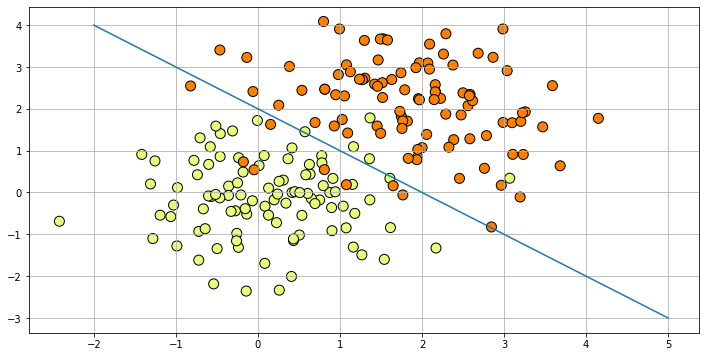

In [17]:
plt.scatter(data[:, 0], data[:, 1], c=target, 
            cmap=plt.get_cmap("Wistia"),
            edgecolors='k', s=100, vmin=0, vmax=1);
plt.plot(np.linspace(-2, 5, 10), np.linspace(4, -3, 10))
plt.grid()

In [18]:
def tree_scatter(data, target, depth, outer=0.1):
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    x_w = x_max - x_min
    y_min, y_max = data[:, 1].min(), data[:, 1].max()
    y_w = y_max - y_min
    xx, yy = np.meshgrid(
        np.arange(x_min - x_w * outer, x_max + x_w * outer, 0.05),
        np.arange(y_min - y_w * outer, x_max + y_w * outer, 0.05),
    )

    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(data, target)
    predict = tree.predict(np.stack([xx.ravel(), yy.ravel()], axis=1))
    plt.pcolormesh(xx, yy, predict.reshape(xx.shape), cmap=plt.get_cmap("Wistia"))
    plt.scatter(data[:, 0], data[:, 1], c=target, 
                cmap=plt.get_cmap("Wistia"),
                edgecolors='k', s=50, vmin=0, vmax=1);
    plt.show()

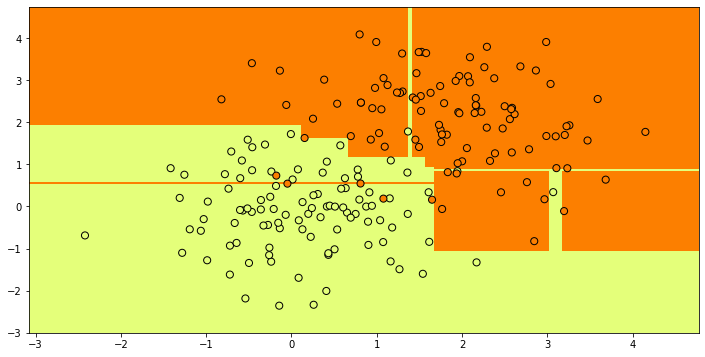

In [19]:
tree_scatter(data, target, 105)

In [20]:
# А теперь рассмотрим сложный случай

data = np.random.uniform(size=(500, 2))
target = np.zeros(data.shape[0])
target[data[:, 0] > data[:, 1]] = 1

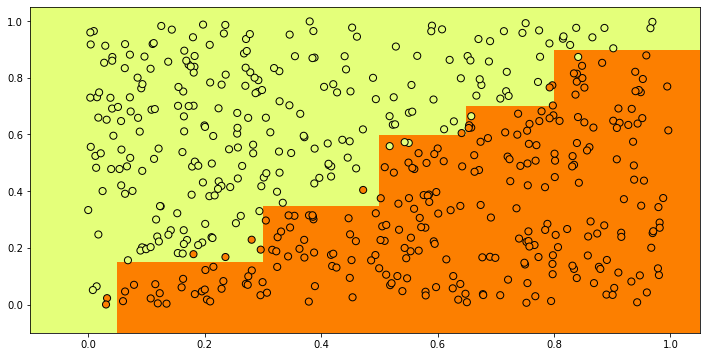

In [21]:
tree_scatter(data, target, 10000, outer=0.1)

## Алгоритмы разбиения

* ID3
* C4.5
* C5.0
* CART (используется в sklearn, но не поддерживает категориальные признаки)

## Регрессия

Алгоритм тот же самый, но в качестве критерия выбирается минимизация среднеквадратичной дисперсии

$$
D = \frac{1}{N} \sum\limits_{i=0}^{N-1} \left(y_i - \frac{1}{N}\sum\limits_{i=0}^{N-1}y_i\right)^2
$$

In [22]:
from sklearn.tree import DecisionTreeRegressor

def reg_test(depth=3):
    f = lambda x: np.sin(x)*np.exp(-x**2/0.5) + np.exp(-(x-np.pi)**2)
    x = np.linspace(-np.pi, np.pi, 50).reshape((50, 1))
    y = f(x)
    noise = np.random.normal(0, 0.1, size=y.shape)
    plt.plot(x, y, '-')
    plt.plot(x, y + noise, '.')

    tree = DecisionTreeRegressor(max_depth=depth)
    tree.fit(x, y + noise)
    x = np.linspace(x.min()-1, x.max()+1, 1000).reshape((1000, 1))
    y = tree.predict(x)
    plt.plot(x, y)
    plt.show()

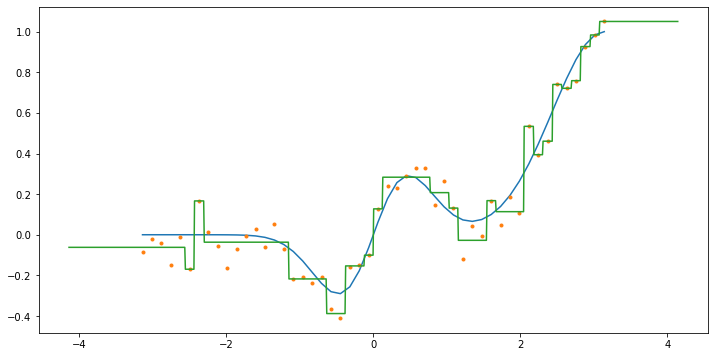

In [23]:
reg_test(5)

## Основные выводы

### Плюсы

* простота интерпретации (дерево - это фактически набор простых правил)
* высокая скорость обучения и прогнозирования
* небольшое число параметров модели
* не требует предварительной подготовки данных
* поддержка всех типов признаков

### Минус

* чувствительность к шумам или к изменениям данных (приводит к порой к кардинально другому дереву)
* разделяющая классы граница не всегда строится эффективно
* ограничение глубины дерева или отсечения ветвей (проблема переобучения)
* сложно поддерживать пропуски в данных
* плохо работает при большом числе признаков
* деревья умеют только интерполировать
* __данный алгоритм сам по себе почти никогда не применяется__

## Гиперпараметры

**Гиперпараметр модели** - некий параметр алгоритма, используемый для анализа данных. Не меняется при обучении.

Для решающих деревьев
 * max_depth - максимальная глубина дерева
 * max_features - максимальное число признаков, по которым ищется лучшее разбиение
 * min_samples_leaf - минимальное число объектов в листе (лист должен быть верен как минимум для этого числа объектов в обучающей выборке)

Как определить значение этих параметров?

## Оценка работы модели

Наша задача создать такую модель, которая сможет предсказывать правильные значения на новых данных, которых не было среди обучающей выборки.

* отложенная выборка - при этом подходе, данные разбиваются на две части: обучающая выборку и тестовую выборку. Стоит использовать тогда, когда данных очень много.
* кросс-валидация (cross-validation), наиболее популярен подход K-fold

<center><img src="cross_validation.png" style="height: 100%; width: auto;padding:10px"></center>

А что если какой-то признак встречается довольно редко и полностью попал в тестовую или обучающую выборку?

## Стратификация

Это довольно простой способ уменьшения разброса оценок. Заключается в том, что мы разбиваем данные на страты по некому признаку. Затем подбираем наши выборки так, чтобы признак встречался приблизительно одинаково часто во всех выборках.

## Пример

In [24]:
df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", index_col='id')
target = df['cardio']

In [25]:
from sklearn.model_selection import train_test_split

train, test, target_train, target_test = train_test_split(
    df[['age','height','weight']], target, 
    test_size=0.3)

In [26]:
# Обучаем модель на тренировочной выборке
tree = DecisionTreeClassifier(max_depth=6, random_state=13)
tree.fit(train, target_train);
predict = tree.predict(test)

# Проверяем всегда на тестовой
from sklearn.metrics import accuracy_score
accuracy_score(predict, target_test)

0.612

In [27]:
train, test, target_train, target_test = train_test_split(
    df[['age','height','weight', 'ap_hi', 'ap_lo']], target, 
    test_size=0.3)
tree = DecisionTreeClassifier(max_depth=5, random_state=13)
tree.fit(train, target_train);
predict = tree.predict(test)

from sklearn.metrics import accuracy_score
accuracy_score(predict, target_test)

0.7233333333333334

In [28]:
from sklearn.model_selection import cross_validate, cross_val_score
data= df[['age','height','weight', 'ap_hi', 'ap_lo']]
target = df['cardio']
tree = DecisionTreeClassifier(max_depth=10, random_state=13)
cv = cross_val_score(tree, 
                    df[['age','height','weight', 'ap_hi', 'ap_lo']], 
                    target,
                    n_jobs=2,
                    scoring='accuracy',
                    cv=3)
cv, cv.mean()

(array([0.7139796 , 0.71606737, 0.71666738]), 0.7155714513121533)

In [29]:
tree = DecisionTreeClassifier(max_depth=50, random_state=13)
cv = cross_val_score(tree, 
                    df[['age','height','weight', 'ap_hi', 'ap_lo']], 
                    target,
                    n_jobs=2,
                    scoring='accuracy',
                    cv=3)
cv, cv.mean()

(array([0.62102511, 0.6208803 , 0.62456607]), 0.6221571590292209)

In [30]:
train, test, target_train, target_test = train_test_split(
    df[['age','height','weight', 'ap_hi', 'ap_lo']], target, 
    test_size=0.3
)

In [31]:
%%time
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': np.arange(2, 10, 1),
    'min_samples_split': [2, 4, 8, 16],
}
tree = DecisionTreeClassifier(random_state=13)
grid = GridSearchCV(
    tree, params, scoring='accuracy',
    cv=3,
)
grid.fit(train, target_train);

Wall time: 4.15 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=13),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [2, 4, 8, 16]},
             scoring='accuracy')

In [32]:
grid.best_score_

0.72138771030611

In [33]:
grid.best_params_

{'max_depth': 5, 'min_samples_split': 2}

In [34]:
predict = grid.best_estimator_.predict(test)
accuracy_score(target_test, predict)

0.723047619047619